In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import preprocessing
sns.set(style='darkgrid')
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


In [2]:
# data loading
questions = pd.read_csv('data/question_data.csv', sep=';')
questions = questions.set_index('Unnamed: 0')  # set first column (question number) as index
questions.index = questions.index.rename('q_id')

In [3]:
data = pd.read_parquet('data/train.parquet')
political_belief = 'q212813'
data.rename({'q212813': 'political_belief'}, axis=1, inplace=True)
data.rename({'Unnamed: 0': 'user_id'}, axis=1, inplace=True)

In [10]:
descriptive_questions = [column for column in data.columns if column.startswith('q')]+['d_gender']
questions.loc[descriptive_questions].head()

,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q_id,,,,,,,,,
q49,Which word describes you better?,Carefree,Intense,NaN,NaN,49827,N,NaN,descriptive
q50,Have you ever seen a therapist?,Yes,No,NaN,NaN,9507,O,NaN,descriptive
q60,Which describes you better?,Warm-hearted,Cool-headed,NaN,NaN,21205,O,NaN,descriptive
q61,Are you a better conversationalist or listener?,Conversationalist,Listener,NaN,NaN,3174,O,NaN,descriptive
q63,Which word describes you better?,Private,Social,NaN,NaN,23765,O,NaN,descriptive


In [17]:
# per question count number of times the question is answered
n_answers_per_question = data[descriptive_questions].count(axis=0)
sorted_questions = n_answers_per_question.sort_values(ascending=False).index
question_data = questions.join(n_answers_per_question.to_frame('n_answers')) 
display(questions.loc[sorted_questions[:10]][['text']])

,text
q416235,Do you like watching foreign movies with subti...
q85419,Which type of wine would you prefer to drink o...
d_gender,Gender
q358084,Do you enjoy intense intellectual conversations?
q501,Have you smoked a cigarette in the last 6 months?
q77,How frequently do you drink alcohol?
q20930,Rate your self-confidence:
q29829,How often do you keep your promises?
q35660,How often are you open with your feelings?
q80,What's your deal with harder drugs (stuff beyo...


# Top K questions df

In [26]:
features_df = data[descriptive_questions]
print(features_df.shape)

(36085, 830)


In [29]:
K=200
subset_size_topk = [features_df.loc[:, sorted_questions[:k]].dropna().shape[0] for k in range(1, K)]

In [32]:
# biggest k with >10.000 subjects who answered ALL k questions
n_most_answered = next(x[0] for x in enumerate(subset_size_topk) if x[1] <= 10000)
n_most_answered

49

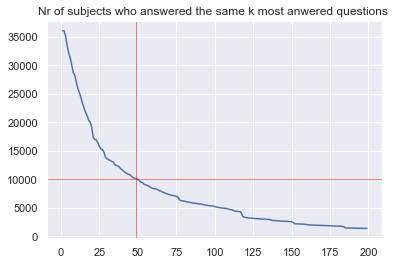

In [33]:
g = sns.lineplot(x = range(1,K), y = subset_size_topk)
g.axhline(y=10000, color='red', linewidth=0.5)
g.axvline(x=n_most_answered, color='red', linewidth=0.5)

#plt.ylim(0,len(features_df))
g.set_title('Nr of subjects who answered the same k most anwered questions ')
plt.show()

# Feature Encoding und Selection

In [34]:
top_questions = sorted_questions[:n_most_answered].to_list()
features_df = features_df[top_questions]
target = data.loc[features_df.index][['political_belief']]

In [218]:
# X_train, X_val, y_train, y_val = train_test_split(features_df, target, test_size=0.15, random_state=1)
# X_train.shape, X_val.shape
# feature_encoder = OneHotEncoder()
# target_encoder = OneHotEncoder()
# X_train_encoded = feature_encoder.fit_transform(X_train)
# y_train_encoded = target_encoder.fit_transform(y_train)
# X_val_encoded = feature_encoder.fit(X_val)
# y_val_encoded = feature_encoder.fit(y_val)

((30672, 830), (5413, 830))

In [35]:
feature_encoder = OrdinalEncoder()
target_encoder = LabelEncoder()
X_train_encoded = feature_encoder.fit_transform(features_df)
y_train_encoded = target_encoder.fit_transform(target)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
fs = SelectKBest(score_func=chi2, k=20)
fs.fit(X_train_encoded, y_train_encoded)
X_train_best_feat = fs.transform(X_train_encoded)
display(X_train_best_feat.shape)
fs.scores_.shape
selected_questions = np.argpartition(fs.scores_, -20)[-20:]
selected_questions = selected_questions[np.argsort(fs.scores_[selected_questions])][::-1]

 

(36085, 20)

Feature 0: Gender: 3518.4968776594073
Feature 1: How important are your political beliefs to you?: 1396.4425043989763
Feature 2: How often do you keep your promises?: 528.0941651171142
Feature 3: Do you say 'Thank you' to wait staff when served in a restaurant?: 454.3716110331503
Feature 4: Are you an aspiring actor/artist/writer or other creative type?: 445.5212666020613
Feature 5: Are you ready to settle down and get married right now?: 372.9803474091204
Feature 6: Do you litter?: 363.7239393199746
Feature 7: You're dating someone new. You discover that they have a housemate the same sex as you. This:: 358.4066012654771
Feature 8: If you had to name your greatest motivation in life thus far, what would it be?: 334.4650888360398
Feature 9: How frequently do you bathe or shower?: 329.01369677484433
Feature 10: What's your relationship with marijuana?: 320.6128247289362
Feature 11: How frequently do you drink alcohol?: 279.70662165665357
Feature 12: Do you like watching foreign movies w

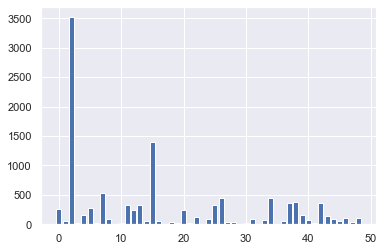

In [37]:
for i, score in enumerate(fs.scores_[selected_questions]):
    print(f'Feature {i}: {questions.loc[sorted_questions[selected_questions[i]]].text}: {score}')

# plot the scores
plt.bar(range(len(fs.scores_)), fs.scores_)
plt.show()

# Model Selection

In [51]:
# Naive Bayes Hyper parameter Tuning
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
nb = CategoricalNB(fit_prior=False)
clf = GridSearchCV(nb, parameters, scoring='balanced_accuracy')  # stratified per default
clf.fit(X_train_best_feat, y_train_encoded)
sorted(clf.cv_results_.keys())
print('mean test score', clf.cv_results_['mean_test_score'])
print('best estimator', clf.best_estimator_)

mean test score [0.44305252 0.44310753 0.44298471 0.44386743 0.44341777 0.41995266
 0.34914062]
best estimator CategoricalNB(alpha=1, fit_prior=False)


In [ ]:
# Logistic
model = LogisticRegression(solver='lbfgs', max_iter=200)
model.fit(X_train, y_train)

In [ ]:

best_alpha = {}

num_folds = 10
n_features = np.power(10, range(-3,3), dtype=float)
k_folds_xs = np.array(np.array_split(xs_train, num_folds), dtype='object')
k_folds_ys = np.array(np.array_split(ys_train, num_folds), dtype='object')

cv_errors_svm = np.ones((len(Cs)))
cv_errors_lr = np.ones((len(Cs)))
for i, c in enumerate(Cs):
    k_fold_errors_svm = []
    k_fold_errors_lr = []
    svm = LinearSVC(C=c)
    lr =  LogisticRegression(C=c)
    for test_index in range(num_folds):
        train_index = np.arange(len(k_folds_xs)) != test_index
        # svm
        svm_estimator = svm.fit(
            np.concatenate(k_folds_xs[train_index]), np.concatenate(k_folds_ys[train_index]))
        k_fold_errors_svm.append( 1 - svm_estimator.score(k_folds_xs[test_index], k_folds_ys[test_index]))
        # lr
        lr_estimator = lr.fit(
            np.concatenate(k_folds_xs[train_index]), np.concatenate(k_folds_ys[train_index]))
        k_fold_errors_lr.append( 1 - lr_estimator.score(k_folds_xs[test_index], k_folds_ys[test_index]))    

    cv_errors_svm[i]= np.mean(k_fold_errors_svm)
    cv_errors_lr[i]= np.mean(k_fold_errors_lr)
    
best_estimator_svm = Cs[np.argmin(cv_errors_svm)]
best_estimator_lr = Cs[np.argmin(cv_errors_lr)]
print(f'best c value for svm, c={best_estimator_svm}')
print(f'best c value for lr, c={best_estimator_lr}')
print(f"Cross validation errors of best model: Linear SVM {cv_errors_svm.min():.4f}, Logistic Regression {cv_errors_lr.min():.4f}")



# Data Distributions

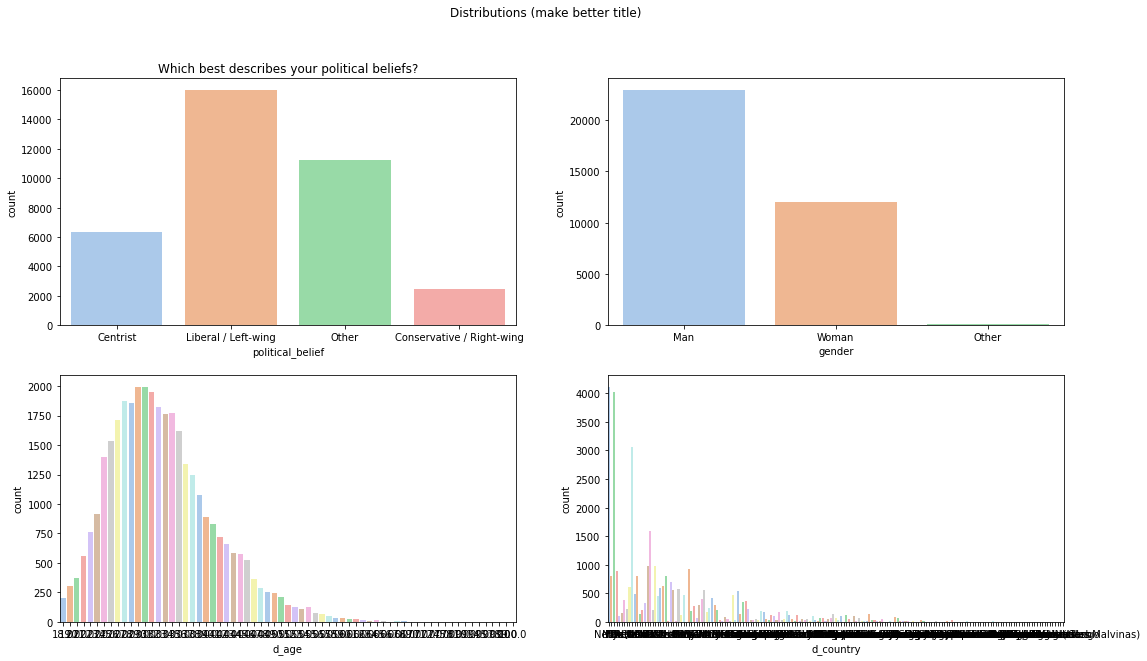

In [148]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
 
fig.suptitle('Distributions (make better title)')

 
sns.countplot(ax=axes[0, 0], data=data, x='political_belief', palette="pastel").set(title=questions.loc['q212813', 'text'])
sns.countplot(ax=axes[0, 1], data=data, x='gender', palette="pastel")
sns.countplot(ax=axes[1, 0], data=data, x='d_age', palette="pastel")
sns.countplot(ax=axes[1, 1], data=data, x='d_country', palette="pastel")
plt.show()

In [149]:
descriptive_questions = [column for column in data.columns if column.startswith('q')]
data['n_q_answered'] = data[descriptive_questions].count(axis=1)

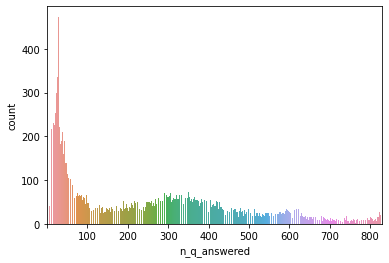

In [150]:
ax = sns.countplot(x=data['n_q_answered'])
ax.set_xticks(range(-2, data['n_q_answered'].max(), 100))
plt.show()